А ещё вот как можно: http://www.ruwordnet.ru/ru/search/МОСКВА

In [1]:
import xmltodict
import os
import pandas as pd
import numpy as np

Скоры на моём тесте и на публичном:
```
* 0.005482            --> 0.0137 (линрег)
* 0.067141            --> 0.0611 (knn)
* 0.102801 (0.096671) --> 0.0593 (knn,  k=10, d=0, положил все синонимы в индекс)
*          (0.1123  ) --> 0.0575534829 (k=10, d=0.3)
*          (0.2111  ) --> 0.0722224826 (k= 3, d=0.3)
*          (0.2666  ) --> 0.0764651814 (k= 1, d=0.3)
```
После правильного пересчёта GT
```
* 0.005482            --> 0.0137 (линрег)
* 0.067141            --> 0.0611 (knn)
* 0.102801 (0.096671) --> 0.0593 (knn,  k=10, d=0, положил все синонимы в индекс)
*          (0.1123  ) --> 0.0575534829 (k=10, d=0.3)
*          (0.2111  ) --> 0.0722224826 (k= 3, d=0.3)
*          (0.2666  ) --> 0.0764651814 (k= 1, d=0.3)
```

Следующий шаг
* положить в knn не по одному слову из синсета, а все (хотя бы - разделённые через запятую), чтобы обогатить пространство соседей. 
* попробовать выкачать другую модель, с бОльшим количеством слов

# Данные

In [2]:
repo_root = '..'

In [3]:
with open('../data/ruwordnet/synsets.N.xml', 'r', encoding='utf-8') as f:
    synsets_n_raw = xmltodict.parse(f.read(), process_namespaces=True)

In [4]:
with open('../data/ruwordnet/synset_relations.N.xml', 'r', encoding='utf-8') as f:
    rel_n_raw = xmltodict.parse(f.read(), process_namespaces=True)

In [5]:
id2synset = {v['@id']: v for v in synsets_n_raw['synsets']['synset']}

In [261]:
from collections import Counter, defaultdict

In [312]:
word2sense = defaultdict(set)

for synset_id, synset in id2synset.items():
    senses = synset['sense']
    if not isinstance(senses, list):
        senses = [senses]
    texts = {sense['#text'] for sense in senses}
    texts.add(synset['@ruthes_name'])
    for text in texts:
        word2sense[text].add(synset_id)
len(word2sense)

86549

In [6]:
rel_df = pd.DataFrame(rel_n_raw['relations']['relation'])

* гиперним - parent частный случай от child 
* гипоним - child более общий, чем parent
* domain - parent относится к теме child
* POS-synonymy - parent и child из разных частей речи
* part holonym - parent является частью child
* part meronym - parent является надсистемой child
* instance hypernym - parent является одним из элементов, множество которых есть child
* instance hyponym - parent является множеством, включающим в себя child. 
* antonym - противоположности (части речи выглядят покоцанными)

Все свойства строго симметричны (кроме POS-synonymy, которая тоже симметрична, но распределена между разными файлами)

In [7]:
rel_df['parent'] = rel_df['@parent_id'].apply(lambda x: id2synset[x]['@ruthes_name'])
rel_df['child'] = rel_df['@child_id'].apply(lambda x: id2synset.get(x, {}).get('@ruthes_name'))

In [8]:
rel_df['@name'].value_counts()

hyponym              37249
hypernym             37249
domain               27339
POS-synonymy         18137
part holonym          3448
part meronym          3448
instance hypernym     1861
instance hyponym      1861
antonym                442
Name: @name, dtype: int64

In [9]:
rel_df[rel_df['@name']=='hyponym'].sample(10)

,@parent_id,@child_id,@name,parent,child
100694,4577-N,138032-N,hyponym,ХИМИЧЕСКОЕ СЫРЬЕ,ПРЕКУРСОР
54726,111501-N,129766-N,hyponym,БРОШЮРА,ОТТИСК СТАТЬИ
8761,123-N,3489-N,hyponym,ШКОЛА,ОБЩЕОБРАЗОВАТЕЛЬНАЯ ШКОЛА
117969,113110-N,131325-N,hyponym,ГАРНИТУР,МЕБЕЛЬНЫЙ ГАРНИТУР
73826,106489-N,107129-N,hyponym,"РЕГУЛИРОВАТЬ, УПОРЯДОЧИВАТЬ",СИСТЕМАТИЗИРОВАТЬ
73764,124141-N,136604-N,hyponym,"ПОДОРВАТЬ, РАСШАТАТЬ",ДИСКРЕДИТИРОВАТЬ
70665,2720-N,114404-N,hyponym,АВТОР,СОАВТОР
88662,111490-N,128317-N,hyponym,СОЮЗ (ОБЪЕДИНЕНИЕ),ФЕДЕРАЦИЯ (ОРГАНИЗАЦИЯ)
76146,148292-N,125159-N,hyponym,АВТОР-ИСПОЛНИТЕЛЬ,БАРД (АВТОР-ИСПОЛНИТЕЛЬ)
74944,107598-N,126386-N,hyponym,РАССУЖДЕНИЕ (УМОЗАКЛЮЧЕНИЕ),КАЗУИСТИКА (РАССУЖДЕНИЕ)


In [10]:
rel_n_raw['relations']['relation'][10000]

OrderedDict([('@parent_id', '5417-N'),
             ('@child_id', '2921-N'),
             ('@name', 'domain')])

In [11]:
synsets_n_raw['synsets']['synset'][10]

OrderedDict([('@id', '7793-N'),
             ('@ruthes_name', 'ПОДВЕДОМСТВЕННОСТЬ СУДАМ'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '7793-N-109004'),
                            ('#text', 'ПОДВЕДОМСТВЕННОСТЬ')]),
               OrderedDict([('@id', '7793-N-208651'),
                            ('#text', 'ПОДВЕДОМСТВЕННОСТЬ СУД')]),
               OrderedDict([('@id', '7793-N-208650'),
                            ('#text', 'ПОДВЕДОМСТВЕННОСТЬ ДЕЛО')]),
               OrderedDict([('@id', '7793-N-215552'),
                            ('#text', 'СУДЕБНЫЙ ПОДВЕДОМСТВЕННОСТЬ')]),
               OrderedDict([('@id', '7793-N-118387'),
                            ('#text', 'СУДЕБНЫЙ ЮРИСДИКЦИЯ')]),
               OrderedDict([('@id', '7793-N-215553'),
                            ('#text', 'ЮРИСДИКЦИЯ СУД')]),
               OrderedDict([('@id', '7793-N-210822'),
                            ('#text', 'НЕП

In [12]:
train_n = pd.read_csv('../data/training_data/training_nouns.tsv', sep='\t', encoding='utf-8')
train_n['parents_list'] = train_n.PARENTS.apply(lambda x: x.split(','))

In [13]:
len(id2synset)

29296

In [14]:
train_n.sample(10)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list
16679,124290-N,ПРОЛЕТАРИЙ,"110125-N,2550-N",NaN,"[110125-N, 2550-N]"
9394,129086-N,ОБЛЕГЧЕНИЕ,"117914-N,106802-N",NaN,"[117914-N, 106802-N]"
6450,4783-N,НАЦИЗМ,"3144-N,600-N,2801-N,6639-N","доктрина, сочетающая фашизм с расизмом; официа...","[3144-N, 600-N, 2801-N, 6639-N]"
14571,125643-N,УКОРЕНЕНИЕ,"125640-N,125642-N,131211-N",NaN,"[125640-N, 125642-N, 131211-N]"
16480,116963-N,КАССА,"1276-N,566-N",NaN,"[1276-N, 566-N]"
16182,104134-N,ЭТНА,"4928-N,3484-N,141139-N",NaN,"[4928-N, 3484-N, 141139-N]"
13423,142063-N,"АРТИСТ,АРТИСТКА,АКТРИСА,ЛИЦЕДЕЙ,ЛИЦЕДЕЙКА,АКТЕР","124715-N,111320-N",NaN,"[124715-N, 111320-N]"
2624,137885-N,ГАЗОНЕПРОНИЦАЕМОСТЬ,"138936-N,107083-N",NaN,"[138936-N, 107083-N]"
13759,129149-N,"ТАТАРСТАНКА,ТАТАРСТАНЕЦ","3291-N,132681-N,1310-N",житель или уроженец Татарстана,"[3291-N, 132681-N, 1310-N]"
15683,4673-N,"ИНКАССО,ИНКАССИРОВАНИЕ,ИНКАССАЦИЯ","151047-N,2181-N,144359-N",посредническая банковская операция по передаче...,"[151047-N, 2181-N, 144359-N]"


In [15]:
id2synset['153504-N']

OrderedDict([('@id', '153504-N'),
             ('@ruthes_name', 'СТАФФОРДШИРСКИЙ ТЕРЬЕР'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '153504-N-749257'),
                            ('#text', 'СТАФФОРДСКИЙ ТЕРЬЕР')]),
               OrderedDict([('@id', '153504-N-749256'),
                            ('#text', 'СТАФФОРДШИРСКИЙ ТЕРЬЕР')]),
               OrderedDict([('@id', '153504-N-749259'),
                            ('#text', 'АМЕРИКАНСКИЙ СТАФФОРДШИРСКИЙ ТЕРЬЕР')]),
               OrderedDict([('@id', '153504-N-128529'),
                            ('#text', 'СТАФФОРД')]),
               OrderedDict([('@id', '153504-N-749258'),
                            ('#text', 'АМСТАФФ')])])])

Все слова из обучающей выборки содержатся и в исходном тезаурусе. Гут. И все родители - тоже. 

In [16]:
len(set(train_n.SYNSET_ID)), len(set(train_n.SYNSET_ID).difference(set(id2synset.keys())))

(12393, 0)

In [17]:
all_parents = {p for pl in train_n.parents_list for p in pl}
len(all_parents), len(all_parents.difference(set(id2synset.keys())))

(8164, 0)

In [18]:
train_n.parents_list.apply(len).describe()

count    16790.000000
mean         2.355152
std          0.555096
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: parents_list, dtype: float64

In [19]:
id2synset['146-N']

OrderedDict([('@id', '146-N'),
             ('@ruthes_name', 'НЕФТЕПРОДУКТ'),
             ('@definition', 'продукт переработки нефти'),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '146-N-182579'),
                            ('#text', 'ПРОДУКЦИЯ НЕФТЕХИМИЧЕСКИЙ КОМПЛЕКС')]),
               OrderedDict([('@id', '146-N-124154'),
                            ('#text', 'НЕФТЕНАЛИВНОЙ ГРУЗ')]),
               OrderedDict([('@id', '146-N-182580'),
                            ('#text', 'ПРОДУКЦИЯ НЕФТЕПЕРЕРАБОТКА')]),
               OrderedDict([('@id', '146-N-107631'),
                            ('#text', 'НЕФТЕПРОДУКТ')]),
               OrderedDict([('@id', '146-N-109923'),
                            ('#text', 'ПРОДУКТ НЕФТЕПЕРЕРАБОТКА')]),
               OrderedDict([('@id', '146-N-117243'),
                            ('#text', 'НЕФТЯНОЙ ПРОДУКТ')])])])

In [20]:
id2synset['8998-N']

OrderedDict([('@id', '8998-N'),
             ('@ruthes_name', 'УГЛЕВОДОРОД'),
             ('@definition',
              'органическое соединение, молекула которого состоит только из атомов углерода и водорода'),
             ('@part_of_speech', 'N'),
             ('sense',
              OrderedDict([('@id', '8998-N-117378'),
                           ('#text', 'УГЛЕВОДОРОД')]))])

In [21]:
id2synset['133238-N']

OrderedDict([('@id', '133238-N'),
             ('@ruthes_name', 'ОРГАНИЧЕСКОЕ ТОПЛИВО'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '133238-N-187338'),
                            ('#text', 'ОРГАНИЧЕСКИЙ ТОПЛИВО')]),
               OrderedDict([('@id', '133238-N-691213'),
                            ('#text', 'ОРГАНИЧЕСКИЙ ГОРЮЧЕЕ')])])])

In [22]:
id2synset['56-N']

OrderedDict([('@id', '56-N'),
             ('@ruthes_name', 'ПРОМЫШЛЕННАЯ ПРОДУКЦИЯ'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '56-N-110034'),
                            ('#text', 'ПРОМЫШЛЕННЫЙ ПРОДУКЦИЯ')]),
               OrderedDict([('@id', '56-N-110039'),
                            ('#text', 'ПРОМЫШЛЕННЫЙ ИЗДЕЛИЕ')]),
               OrderedDict([('@id', '56-N-120875'),
                            ('#text', 'ПРОМЫШЛЕННЫЙ ПРОДУКТ')]),
               OrderedDict([('@id', '56-N-722047'),
                            ('#text', 'ФАБРИЧНЫЙ ПРОДУКЦИЯ')]),
               OrderedDict([('@id', '56-N-103811'),
                            ('#text', 'ПРОДУКЦИЯ ПРОМЫШЛЕННОСТЬ')]),
               OrderedDict([('@id', '56-N-109931'),
                            ('#text',
                             'ПРОДУКЦИЯ ПРОМЫШЛЕННЫЙ ПРЕДПРИЯТИЕ')])])])

Например: МАЗУТ вообще не входит в нашу таксономию, но вот зато он есть в обучающей выборке. 

In [23]:
id2synset['147-N']

OrderedDict([('@id', '147-N'),
             ('@ruthes_name', 'МАЗУТ'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '147-N-217729'),
                            ('#text', 'ОСТАТОЧНЫЙ НЕФТЕПРОДУКТ')]),
               OrderedDict([('@id', '147-N-217730'),
                            ('#text', 'НЕФТЯНОЙ ОСТАТОК')]),
               OrderedDict([('@id', '147-N-106087'), ('#text', 'МАЗУТ')])])])

In [24]:
rel_df[rel_df.child=='147-N']

,@parent_id,@child_id,@name,parent,child


Возможная стратегия решения:
* Для каждого синсета вычисляем эмбеддинг
* Выучиваем функцию из эмбеддинга гиперонима в эмбеддинг гипонима (можно ещё обратную, для надёжности)
* Для каждого нового слова вычисляем координаты предположительного гипонима. 
* Берём ближайших соседей предположительного гипонима. Это наши кандидаты. 
* Для каждой кандидатной пары применяем скоринговую функцию (от двух эмбеддингов и возможно чего-то ещё), предсказывающую вероятность, что эта пара корректная
* Ранжируем кандидаты-гипонимы этой функцией
* Делаем рекурсивное замыкание этой фигни, на каждом следующем шаге домножая на вероятности-скоры
* Финальный список кандидатов - топ всех результатов рекурсии, отранжированный по произведению всех вероятностей. 

In [25]:
len(id2synset)

29296

In [88]:
public_test_nouns = pd.read_csv('../data/public_test/nouns_public.tsv', header=None, encoding='utf-8')
public_test_nouns.columns = ['noun']

In [377]:
public_test_nouns.shape

(762, 1)

In [89]:
def prepare_submission(words, hypotheses, id2synset):
    result_nouns = []
    result_hyperonyms = []
    result_hyper_names = []
    for n, h in zip(words, hypotheses):
        for hypo in h:
            result_nouns.append(n)
            result_hyperonyms.append(hypo)
            result_hyper_names.append(id2synset[hypo]['@ruthes_name'])
    result_df = pd.DataFrame({'noun': result_nouns, 'result': result_hyperonyms, 'result_text': result_hyper_names})
    return result_df

# Оценка качества

In [26]:
import sys
import os
def add_sys_path(p):
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

add_sys_path('..')

In [27]:
import evaluate

In [28]:
assert evaluate.compute_ap([], [], k=10) == 0

assert evaluate.compute_ap([{'lol'}, {'kek'}], ['kek', 'lol'], k=10) == 1.0
assert evaluate.compute_ap([{'lol'}, {'not kek'}], ['kek'], k=10) == 0.0
assert evaluate.compute_ap([{'lol'}, {'not kek'}, {'cheburek'}], ['not kek'], k=10) == sum([1]) / 3
assert evaluate.compute_ap([{'lol'}, {'not kek'}, {'cheburek'}], ['not kek', 'zhopa'], k=10) == sum([1, 0]) / 3
assert evaluate.compute_ap([{'lol'}, {'not kek'}, {'cheburek'}], ['zhopa', 'not kek'], k=10) == sum([0, 0.5]) / 3

In [29]:
train_n.shape[0], train_n.SYNSET_ID.nunique()

(16790, 12393)

In [30]:
import hashlib
def hash_float(text, salt='1', base=1000000):
    return int(hashlib.sha256((text+salt).encode('utf-8')).hexdigest(), 16) % base / base

In [33]:
train_n['synset_hash'] = train_n.SYNSET_ID.apply(hash_float)
train_n['one_text'] = train_n.TEXT.apply(lambda x: sorted(x.split(','), key=hash_float)[0])

In [34]:
train_n.sample(5)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
3343,125531-N,"ВБИВАНИЕ,ВДАЛБЛИВАНИЕ","120095-N,111611-N",NaN,"[120095-N, 111611-N]",0.075422,ВДАЛБЛИВАНИЕ
4824,111434-N,"БЕШЕНСТВО,ЯРОСТЬ","107062-N,107058-N","крайняя степень раздражения, буйная ярость","[107062-N, 107058-N]",0.107961,ЯРОСТЬ
5396,132685-N,МИШУРА,"108669-N,106554-N",NaN,"[108669-N, 106554-N]",0.584092,МИШУРА
9792,108788-N,КАНИСТРА,"121685-N,107039-N",NaN,"[121685-N, 107039-N]",0.836040,КАНИСТРА
1052,128641-N,"РАЗЗАДОРИВАНИЕ,ПОДНАЧИВАНЬЕ,ПОДНАЧКА,ПОДЗАДОРИ...","110474-N,106473-N",NaN,"[110474-N, 106473-N]",0.902552,ПОДНАЧИВАНЬЕ


In [42]:
ttrain = train_n[train_n.synset_hash <= 0.8]
ttest = train_n[train_n.synset_hash > 0.8]
ttest_dev = ttest[ttest.synset_hash <= 0.82]
ttest_test1 = ttest[(ttest.synset_hash > 0.82) & (ttest.synset_hash <= 0.84)]
ttest_test2 = ttest[(ttest.synset_hash > 0.84) & (ttest.synset_hash <= 0.86)]
ttest_hidden = ttest[(ttest.synset_hash > 0.86)]

forbidden_id = set(ttest.SYNSET_ID)

In [405]:
ttest_dev.to_pickle('ttest_dev.pkl')
ttest_test1.to_pickle('ttest_test1.pkl')

In [43]:
train_n.head(10)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
0,120440-N,"УСМЕШКА,УХМЫЛКА","112039-N,126984-N,112037-N",NaN,"[112039-N, 126984-N, 112037-N]",0.378537,УХМЫЛКА
1,120440-N,"УСМЕШКА,УХМЫЛКА","116284-N,141697-N",NaN,"[116284-N, 141697-N]",0.378537,УХМЫЛКА
2,1746-N,ОКУПАЕМОСТЬ,"7072-N,2116-N,107583-N",NaN,"[7072-N, 2116-N, 107583-N]",0.367679,ОКУПАЕМОСТЬ
3,141479-N,МОНЕТИЗАЦИЯ,"7072-N,2116-N,107583-N",NaN,"[7072-N, 2116-N, 107583-N]",0.904428,МОНЕТИЗАЦИЯ
4,147246-N,СОБИРАЕМОСТЬ,"7072-N,2116-N,107583-N",NaN,"[7072-N, 2116-N, 107583-N]",0.979079,СОБИРАЕМОСТЬ
5,149509-N,КАПИТАЛИЗАЦИЯ,"7072-N,2116-N,107583-N",NaN,"[7072-N, 2116-N, 107583-N]",0.674827,КАПИТАЛИЗАЦИЯ
6,149509-N,КАПИТАЛИЗАЦИЯ,"149212-N,150878-N,147449-N",NaN,"[149212-N, 150878-N, 147449-N]",0.674827,КАПИТАЛИЗАЦИЯ
7,109570-N,КРУИЗ,"5920-N,106587-N,2661-N",NaN,"[5920-N, 106587-N, 2661-N]",0.713627,КРУИЗ
8,109570-N,КРУИЗ,"137121-N,2661-N,134047-N,152303-N",NaN,"[137121-N, 2661-N, 134047-N, 152303-N]",0.713627,КРУИЗ
9,109570-N,КРУИЗ,"143590-N,5920-N,2661-N,152303-N",NaN,"[143590-N, 5920-N, 2661-N, 152303-N]",0.713627,КРУИЗ


In [40]:
hypernyms_ids = set(rel_df['@parent_id'][rel_df['@name']=='hypernym'])
print(len(hypernyms_ids))
print(len(hypernyms_ids.intersection(set(ttest.SYNSET_ID))))

28101
2302


In [244]:
ids = sorted(set(id2synset.keys()).difference(forbidden_id))
len(ids)

26837

In [148]:
def evaluate_mine(hypotheses, texts, gt_table):
    gts = defaultdict(list)
    for r, row in gt_table.iterrows():
        gts[row.one_text].append(row.parents_list)
    aps = pd.Series([evaluate.compute_ap(gts[w], hyps, k=10) for w, hyps in zip(texts, hypotheses)])
    return aps, gts

# Бейзлайн

In [37]:
import gensim
# this is araneum 2018 ft model from rusvectores
ft = gensim.models.fasttext.FastTextKeyedVectors.load(
    'C:/Users/ddale/Downloads/NLP/rusvectores/model.model'
)
ft.adjust_vectors()

In [38]:
from nltk import wordpunct_tokenize
from string import punctuation

def tokenize(text):
    return [t for t in wordpunct_tokenize(text.lower()) if not all(c in punctuation for c in t)]

def mean_ft(tokens, n=300):
    vecs = [normalize(ft[w]) for w in tokens]
    if len(vecs) == 0:
        return np.zeros(n)
    return normalize(sum(vecs))

def normalize(v):
    return v / sum(v**2)**0.5

In [39]:
ids = sorted(id2synset.keys())

In [40]:
from tqdm.auto import tqdm, trange

In [41]:
def text2vec(text):
    return mean_ft(tokenize(text))

In [59]:
ids_long = []
texts_long = []
for id in ids:
    s = id2synset[id]
    senses = s['sense']
    if not isinstance(senses, list):
        senses = [senses]
    texts = {sense['#text'] for sense in senses}
    texts.add(s['@ruthes_name'])
    if len(texts) > 1:
        texts.add(' ; '.join(sorted(texts)))
    for text in sorted(texts):
        ids_long.append(id)
        texts_long.append(text)
print(len(ids), len(ids_long))

29296 119273


In [60]:
#vecs = np.stack([mean_ft(tokenize(id2synset[idx]['@ruthes_name'])) for idx in tqdm(ids) ])
vecs = np.stack([mean_ft(tokenize(t)) for t in tqdm(texts_long) ])
vecs.shape

(119273, 300)

In [63]:
ttrain.shape

(8395, 5)

In [64]:
ttrain.sample(10)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list
3975,136656-N,ЭХОЛОКАЦИЯ,"112514-N,106710-N",NaN,"[112514-N, 106710-N]"
5472,105496-N,"МАРОККАНЕЦ,МАРОККАНКА","105413-N,134850-N,106131-N","гражданин, житель или уроженец Марокко","[105413-N, 134850-N, 106131-N]"
540,1238-N,СЕБЕСТОИМОСТЬ,"1759-N,2116-N",NaN,"[1759-N, 2116-N]"
4637,113452-N,ПОДЪЕЗД,"106587-N,135044-N",приближаться на транспортном средстве к какому...,"[106587-N, 135044-N]"
6123,5671-N,ДАМБА,"107559-N,107558-N",насыпь или вал на берегах для предохранения от...,"[107559-N, 107558-N]"
4769,5421-N,НЕДОИМКА,"6179-N,647-N",не уплаченная в срок часть налога или какого-л...,"[6179-N, 647-N]"
9459,536-N,"ХИМНЕФТЕПРОМ,НЕФТЕХИМПРОМ,НЕФТЕХИМИЯ","533-N,7127-N,531-N",NaN,"[533-N, 7127-N, 531-N]"
9863,111125-N,НИКОТИН,"1011-N,959-N","алкалоид, содержащийся в растениях семейства п...","[1011-N, 959-N]"
494,972-N,МИНЕРАЛКА,"550-N,549-N",NaN,"[550-N, 549-N]"
11407,4639-N,"АСФАЛЬТИРОВКА,АСФАЛЬТИРОВАНИЕ","111871-N,107325-N",NaN,"[111871-N, 107325-N]"


In [65]:
id2idx = {name: idx for idx, name in  enumerate(ids)}

In [492]:
from collections import defaultdict

def add_pair(hypo_id, hyper_id, max_depth=100500):
    if max_depth <= 0:
        return
    if hypo_id in id2hyponym[hyper_id]:
        # the pair is already here
        return 
    if hypo_id in id2hypernym[hyper_id]:
        raise ValueError('{} is already a hypernym of {}, so it cannot become its hyponym'.format(hypo_id, hyper_id))
    for next_hypo in id2hyponym[hypo_id]:
        add_pair(next_hypo, hyper_id, max_depth=max_depth-1)
    for next_hyper in id2hypernym[hyper_id]:
        add_pair(hypo_id, next_hyper, max_depth=max_depth-1)
    id2hyponym[hyper_id].add(hypo_id)
    id2hypernym[hypo_id].add(hyper_id)
        

* До обогащения (все предки): 28118 ключей, 268'637 пар, максимальное число предков - 63
* До обогащения (максимум бабушка): 28118 ключей, 141'576 пар, максимальное число предков - 24
* До обогащения (максимум мать): 28118 ключей, 37'249 пар, максимальное число предков - 5
* До обогащения (без тестовых детей): 25816 ключей, 34165 пар, максимальное число предков - 5

In [556]:
id2hyponym = defaultdict(set)
id2hypernym = defaultdict(set)
forbidden_id = set(ttest.SYNSET_ID)

hypo_df = rel_df[rel_df['@name']=='hyponym']
for r, row in tqdm(hypo_df.iterrows()):
    hypo_id = row['@child_id']
    hyper_id = row['@parent_id']
    if hypo_id not in forbidden_id and hyper_id not in forbidden_id:
        add_pair(hypo_id, hyper_id, max_depth=1)  # во второй версии поставим максимальную глубину, равную 2

In [552]:
rel_df.sample(10)

,@parent_id,@child_id,@name,parent,child
59111,116610-N,117306-N,hyponym,ПЕРЕНЕСТИ НА ДРУГОЕ МЕСТО,СМЫТЬ ТЕЧЕНИЕМ
11198,135523-N,6668-N,hypernym,СТАТС-СЕКРЕТАРЬ,ГОСУДАРСТВЕННЫЙ СЛУЖАЩИЙ
62842,101204-N,101206-N,part meronym,КАРАЧАЕВО-ЧЕРКЕССИЯ,КАРАЧАЕВСК
41097,145635-N,145635-A,POS-synonymy,ТРАНСПОРТНЫЙ КОНВОЙ,None
49252,107696-N,107696-V,POS-synonymy,ПРАВО (ВОЗМОЖНОСТЬ),None
69848,145633-N,111437-N,hypernym,КОНСЕРВИРОВАТЬ (ПРЕДОХРАНИТЬ ОТ ПОРЧИ),"ПРЕДОХРАНИТЬ (ЗАРАНЕЕ ОХРАНИТЬ, ОБЕРЕЧЬ)"
116601,154154-N,50-N,domain,КИСЛОРОДНАЯ МАСКА,ПРОМЫШЛЕННОСТЬ
39403,107429-N,7131-N,hyponym,"ОСТАТОК, ОСТАВШАЯСЯ ЧАСТЬ",ОТРУБИ
470,112701-N,6293-N,domain,САНДАЛ (ДЕРЕВО),БОТАНИКА
2114,136183-N,6527-N,hypernym,ПОЛИЦЕЙСКИЙ,СОТРУДНИК ПРАВООХРАНИТЕЛЬНЫХ ОРГАНОВ


In [555]:
id2hyperym['9464-N']

NameError: name 'id2hyperym' is not defined

In [553]:
rel_df[rel_df.parent=='НЕВРОЛОГИЯ']

,@parent_id,@child_id,@name,parent,child
1969,9464-N,9464-A,POS-synonymy,НЕВРОЛОГИЯ,None
1970,9464-N,1047-N,hypernym,НЕВРОЛОГИЯ,МЕДИЦИНА
1971,9464-N,9465-N,hyponym,НЕВРОЛОГИЯ,НЕВРОПАТОЛОГИЯ
1972,9464-N,1047-N,domain,НЕВРОЛОГИЯ,МЕДИЦИНА


In [495]:
print(len(id2hyponym))
print(max(len(c) for c in id2hyponym.values()))
print(max(len(c) for c in id2hypernym.values()))
print(sum(len(c) for c in id2hypernym.values()))

25816
446
5
34165


In [324]:
import random
key = random.choice(list(id2hypernym.keys()))
print(id2synset[key]['@ruthes_name'])
for v in id2hypernym[key]:
    print(id2synset[v]['@ruthes_name'])

ПОЗДРАВИТЬ
ВЫСКАЗАТЬ МНЕНИЕ
ВЫСКАЗАТЬ
СООБЩИТЬ, УВЕДОМИТЬ
СОГЛАСИТЬСЯ, ДАТЬ СОГЛАСИЕ
ПРОИСХОДЯЩАЯ СУЩНОСТЬ
ПОСТУПОК ЧЕЛОВЕКА
ОДОБРИТЬ
ДЕЙСТВИЕ ЧЕЛОВЕКА
ОТВЕТИТЬ, ПОСТУПИТЬ В ОТВЕТ
ДЕЙСТВИЕ, ЦЕЛЕНАПРАВЛЕННОЕ ДЕЙСТВИЕ


Теперь добавляем объектов из обучающей выборки. Кажется, что после обогащения не особо что-то изменилось. 

In [361]:
ttrain.sample(3)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list
5038,3191-N,ТЕХЗАДАНИЕ,"5875-N,2428-N",NaN,"[5875-N, 2428-N]"
12704,125133-N,"ВЗДОР,ГЛУПОСТЬ,ДИЧЬ,ЕРУНДА,ЛАБУДА,МУРА,МУТЬ,ТА...","124894-N,107257-N","нечто неважное, бессмысленное, чепуха","[124894-N, 107257-N]"
15350,144328-N,БОЯРЫШНИК,"107842-N,107871-N,144341-N",NaN,"[107842-N, 107871-N, 144341-N]"


In [327]:
for r, row in tqdm(ttrain.iterrows(), total=ttrain.shape[0]):
    hypo_id = row['SYNSET_ID']
    for hyper_id in row.parents_list:
        add_pair(hypo_id, hyper_id)

In [328]:
print(len(id2hyponym))
print(max(len(c) for c in id2hyponym.values()))
print(max(len(c) for c in id2hypernym.values()))
print(sum(len(c) for c in id2hypernym.values()))

28636
18928
63
274902


In [79]:
hypo_indices = []
hyper_indices = []
for key, values in id2hyponym.items():
    for value in values:
        hypo_indices.append(value)
        hyper_indices.append(key)

In [85]:
synX = vecs[[id2idx[ix] for ix in hypo_indices]]
synY = vecs[[id2idx[ix] for ix in hyper_indices]]

In [90]:
synX.var(axis=0).mean()

0.0025339746

In [96]:
(synX-synY).var(axis=0).mean()

0.004187228

In [92]:
from sklearn.linear_model import LinearRegression

In [93]:
linreg = LinearRegression().fit(synX, synY)

In [94]:
pred = linreg.predict(synX)

In [97]:
(synY-pred).var(axis=0).mean()

0.0021273529

Ага! Линейная регрессия немножко помогает :)

In [103]:
pred_norm = (pred.T / ((pred**2).sum(axis=1)**0.5)).T

Удивительно, но после нормализации MSE только возрастает. 

In [104]:
(synY-pred_norm).var(axis=0).mean()

0.0021941925

In [136]:
from sklearn.neighbors import KDTree

In [137]:
tree = KDTree(vecs)

#### пример работы моего алгоритма

In [217]:
row = ttrain.sample(1)

for p in row.parents_list.iloc[0]:
    print(id2synset[p]['@ruthes_name'])
row

ДИПЛОМАТИЧЕСКИЙ РАБОТНИК
ДОЛЖНОСТНОЕ ЛИЦО
РАБОТНИК ЗАГРАНУЧРЕЖДЕНИЯ
ПРЕДСТАВИТЕЛЬ ИНТЕРЕСОВ


,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list
13636,127185-N,НУНЦИЙ,"1179-N,3361-N,8688-N,106891-N",NaN,"[1179-N, 3361-N, 8688-N, 106891-N]"


ТЕКСТИЛЬЩИК
РАБОТНИК ЛЕГКОЙ ПРОМЫШЛЕННОСТИ


In [174]:
vec = vecs[id2idx[row.SYNSET_ID.iloc[0]]].reshape(1, -1)

In [175]:
vec_pred = normalize(linreg.predict(vec).ravel())

In [176]:
distances, indices = tree.query(vec_pred.reshape(1, -1), k=10)

In [177]:
for i, d in zip(indices.ravel(), distances.ravel()):
    print(d, ids[i], id2synset[ids[i]]['@ruthes_name'])

0.6634564139419517 150414-N БИОЛОГИЧЕСКАЯ СУЩНОСТЬ
0.6879088440684842 147509-N ЭНЕРГИЯ ЧЕЛОВЕКА
0.6916229001163239 145529-N ФУНКЦИОНАЛЬНАЯ НЕДОСТАТОЧНОСТЬ ОРГАНА
0.6940315004049996 147134-N ФИЗИЧЕСКАЯ СУЩНОСТЬ
0.6955260006298274 142922-N КОНСТИТУЦИОНАЛЬНЫЕ ОСОБЕННОСТИ ОРГАНИЗМА
0.6966659523655019 150555-N ЧЕЛОВЕК ПО СФЕРЕ ДЕЯТЕЛЬНОСТИ
0.6983008243630823 140126-N СОЦИАЛЬНО-ДЕМОГРАФИЧЕСКАЯ ОБЩНОСТЬ
0.7105105770528403 139946-N СОЦИАЛЬНАЯ ОБЩНОСТЬ
0.722326210037546 153782-N ПОСТОЯННАЯ СУЩНОСТЬ
0.7238719449947625 125061-N СУБЪЕКТ СУЖДЕНИЯ


In [204]:
def vec2hypo(vec):
    vec_pred = normalize(linreg.predict(vec.reshape(1, -1)).ravel())
    distances, indices = tree.query(vec_pred.reshape(1, -1), k=10)
    return [ids[i] for i in indices.ravel()]

def get_hypotheses(id):
    vec = vecs[id2idx[id]]
    return vec2hypo(vec)

In [205]:
get_hypotheses('8667-N')

['150414-N',
 '147509-N',
 '145529-N',
 '147134-N',
 '142922-N',
 '150555-N',
 '140126-N',
 '139946-N',
 '153782-N',
 '125061-N']

In [182]:
ttest_hypotheses = [get_hypotheses(id) for id in tqdm(ttest.SYNSET_ID)]

In [185]:
ttest_gt = ttest.parents_list.apply(lambda x: [{c} for c in x]).tolist()

In [187]:
ttest_gt[0]

[{'119261-N'}, {'106775-N'}]

In [188]:
ttest_hypotheses[0]

['147134-N',
 '150414-N',
 '153782-N',
 '136567-N',
 '142922-N',
 '153471-N',
 '146671-N',
 '106569-N',
 '123796-N',
 '125061-N']

In [192]:
aps = pd.Series([evaluate.compute_ap(gt, hyps, k=10) for gt, hyps in zip(ttest_gt, ttest_hypotheses)])

In [193]:
aps.describe()

count    8395.000000
mean        0.005482
std         0.037432
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.555556
dtype: float64

In [194]:
(aps>0).mean()

0.03704586063132817

In [195]:
aps[aps>0].describe()

count    311.000000
mean       0.147967
std        0.129571
min        0.022222
25%        0.062500
50%        0.111111
75%        0.166667
max        0.555556
dtype: float64

# Сабмитим бейзлайн

In [198]:
public_test_nouns = pd.read_csv('../data/public_test/nouns_public.tsv', header=None, encoding='utf-8')
public_test_nouns.columns = ['noun']

In [199]:
len(set(public_test_nouns['noun'])), len(set(public_test_nouns['noun']).difference())

762

In [202]:
public_test_nouns.sample(5)

,noun
686,ФЛУКТУАЦИЯ
107,ВОСКРЕСНИК
148,ГУДРОН
192,ЖБАН
633,ТАБАКОВОДСТВО


In [203]:
public_test_embs = np.stack([mean_ft(tokenize(x)) for x in tqdm(public_test_nouns['noun']) ])

In [206]:
public_test_hypos = [vec2hypo(v) for v in tqdm(public_test_embs)]

In [209]:
result_df = prepare_submission(public_test_nouns.noun, public_test_hypos, id2synset)
result_df.sample(10)

In [216]:
result_df.to_csv('nouns_ft_linreg_v1.tsv', sep='\t', encoding='utf-8', header=None, index=None)

# Второй подход: метод ближайших соседей

А что, если находить "родителей", просто глядя на предков похожих текстов?

In [232]:
row = ttrain.sample(1)

for p in row.parents_list.iloc[0]:
    print(id2synset[p]['@ruthes_name'])
row

КОПЧЕНЫЕ МЯСНЫЕ ПРОДУКТЫ
МЯСНЫЕ ПРОДУКТЫ
КОПЧЕНЫЕ ПРОДУКТЫ


,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list
12592,109065-N,БЕКОН,"108355-N,108354-N,143722-N",NaN,"[108355-N, 108354-N, 143722-N]"


In [233]:
vec = vecs[id2idx[row.SYNSET_ID.iloc[0]]]

distances, indices = tree.query(vec.reshape(1, -1), k=10)

for i, d in zip(indices.ravel(), distances.ravel()):
    print(d, ids[i], id2synset[ids[i]]['@ruthes_name'])

0.0 109065-N БЕКОН
0.8712710167339206 150730-N ТМИН (ПРЯНОСТЬ)
0.8841478623142824 108934-N ШАМПИНЬОН
0.8960343825610356 144272-N МЯСНОЕ ФИЛЕ
0.8995815147611657 109097-N ВЕРМИШЕЛЬ
0.9025935634314826 109769-N САРДИНА
0.9049464338759658 143187-N ЧИПСЫ
0.9052300484934338 107975-N АНЧОУС
0.9117641744036451 111660-N ПЕРЕЦ (ПРЯНОСТЬ)
0.9121563760060882 109768-N САРДЕЛЬКА


In [263]:
from collections import Counter

In [378]:
text = public_test_nouns.noun.sample(1).iloc[0]
print(text)
vec = text2vec(text)
distances, indices = tree.query(vec.reshape(1, -1), k=10)

hypotheses = Counter()

for i, d in zip(indices.ravel(), distances.ravel()):
    print(d, ids[i], id2synset[ids[i]]['@ruthes_name'])
    for parent in id2hypernym.get(ids[i], set()):
        hypotheses[parent] += 1
print(len(hypotheses))
for hypo, cnt in hypotheses.most_common(10):
    print(cnt, hypo, id2synset[hypo]['@ruthes_name'])

ДАЛЬТОНИК
0.908786353357731 106371-N ДАЛЛАС
0.93271615402465 142698-N ТОНИК
0.9738889412194028 125980-N ДАЛЬНОМЕР
0.9810747714139905 140495-N САНТА-БАРБАРА
0.9834304232131871 105005-N КОЛОМБО
0.9963476631222952 105193-N СЕНТ-ВИНСЕНТ
0.9964537579113368 140703-N РИМЕЙК ФИЛЬМА
0.996730228507747 104693-N СЕНТ-ЛЮСИЯ
0.9986403244813133 136332-N БРЕЙК-ДАНС
1.002067081091842 127132-N ПЕРЕЛЕТ (ПАДЕНИЕ ДАЛЬШЕ ЦЕЛИ)
67
7 153782-N ПОСТОЯННАЯ СУЩНОСТЬ
5 147134-N ФИЗИЧЕСКАЯ СУЩНОСТЬ
4 149182-N ПУБЛИЧНО-ПРАВОВОЕ ОБРАЗОВАНИЕ
4 149189-N СУБЪЕКТ ПРАВА
4 138167-N СУБЪЕКТ ДЕЯТЕЛЬНОСТИ
3 123680-N МУНИЦИПАЛЬНОЕ ОБРАЗОВАНИЕ
3 590-N НАСЕЛЕННЫЙ ПУНКТ
3 2052-N АДМИНИСТРАТИВНО-ТЕРРИТОРИАЛЬНАЯ ЕДИНИЦА
3 145516-N ГОРОДСКОЕ ПОСЕЛЕНИЕ
3 7166-N ГЕОГРАФИЧЕСКИЙ ОБЪЕКТ


In [283]:
def hypotheses_knn(text, index, k=10, verbose=False):
    vec = text2vec(text)
    distances, indices = index.query(vec.reshape(1, -1), k=k)
    hypotheses = Counter()
    for i, d in zip(indices.ravel(), distances.ravel()):
        if verbose:
            print(d, ids[i], id2synset[ids[i]]['@ruthes_name'])
        for parent in id2hypernym.get(ids[i], set()):
            hypotheses[parent] += 1
    if verbose:
        print(len(hypotheses))
    result = []
    for hypo, cnt in hypotheses.most_common(10):
        if verbose:
            print(cnt, hypo, id2synset[hypo]['@ruthes_name'])
        result.append(hypo)
    return result

In [288]:
hypotheses_knn('тетерев', index=tree, verbose=True)

0.0 108058-N ТЕТЕРЕВ
0.7437579398387988 8956-N ГЛУХАРЬ
0.7674193551437258 143552-N СЕМЕЙСТВО ТЕТЕРЕВИНЫЕ
0.7996734758427403 8911-N КУРОПАТКА
0.8146013732630116 107767-N ЖУРАВЛЬ (ПТИЦА)
0.8384177525280063 107811-N ВОРОНА (ПТИЦА)
0.8384968496822458 108189-N ОВСЯНКА (ПТИЦА)
0.8472328710193752 102893-N ТЕТЕРЕВ (ПРИТ. ДНЕПРА)
0.8545029887220364 134699-N РЯБЧИК
0.8639614736208439 107927-N КУКУШКА (ПТИЦА)
21
10 153782-N ПОСТОЯННАЯ СУЩНОСТЬ
10 147134-N ФИЗИЧЕСКАЯ СУЩНОСТЬ
9 963-N ПТИЦА
9 150414-N БИОЛОГИЧЕСКАЯ СУЩНОСТЬ
9 106579-N ЖИВОЙ ОРГАНИЗМ
9 144174-N ЖИВОТНОЕ
8 4091-N ДИКОЕ ЖИВОТНОЕ
8 5681-N ДИКАЯ ПТИЦА
5 141894-N ПЕРНАТАЯ ДИЧЬ
5 145929-N ОХОТНИЧЬЕ-ПРОМЫСЛОВЫЕ ЖИВОТНЫЕ


['153782-N',
 '147134-N',
 '963-N',
 '150414-N',
 '106579-N',
 '144174-N',
 '4091-N',
 '5681-N',
 '141894-N',
 '145929-N']

In [289]:
ttest.sample(3)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list
4203,131140-N,"ЗАГНОЕНИЕ,ГНОЕНИЕ","120550-N,125011-N,152470-N",NaN,"[120550-N, 125011-N, 152470-N]"
13749,138126-N,УДАРОПРОЧНОСТЬ,"127016-N,118598-N,119010-N",NaN,"[127016-N, 118598-N, 119010-N]"
15441,136755-N,ЭМБОЛИЯ,"136754-N,6129-N,119562-N",NaN,"[136754-N, 6129-N, 119562-N]"


In [296]:
ttest_hypotheses = [hypotheses_knn(txt, index=tree) for txt in tqdm(ttest.TEXT)]

In [298]:
aps = pd.Series([evaluate.compute_ap(gt, hyps, k=10) for gt, hyps in zip(ttest_gt, ttest_hypotheses)])
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()

0.3970220369267421
0.16911255808120496


count    8395.000000
mean        0.067141
std         0.121018
min         0.000000
25%         0.000000
50%         0.000000
75%         0.083333
max         1.000000
dtype: float64

In [293]:
public_test_hypos = [hypotheses_knn(t, index=tree) for t in tqdm(public_test_nouns.noun)]

In [362]:
pd.Series(public_test_hypos).apply(len).describe()

count    762.000000
mean       9.994751
std        0.144905
min        6.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       10.000000
dtype: float64

In [294]:
result_nouns = []
result_hyperonyms = []
result_hyper_names = []
for n, h in zip(public_test_nouns.noun, public_test_hypos):
    for hypo in h:
        result_nouns.append(n)
        result_hyperonyms.append(hypo)
        result_hyper_names.append(id2synset[hypo]['@ruthes_name'])
result_df = pd.DataFrame({'noun': result_nouns, 'result': result_hyperonyms, 'result_text': result_hyper_names})
result_df.sample(10)

,noun,result,result_text
3454,МЕДИАНА,106451-N,МЕСТО В ПРОСТРАНСТВЕ
6999,ХАРЧО,107778-N,КУШАНЬЕ
3232,ЛОБСТЕР,820-N,ВЕЩЕСТВО
4438,ПАНТОГРАФ,111816-N,СОЗДАТЕЛЬ
2031,ЗАТОВАРИВАНИЕ,106473-N,"ОБУСЛАВЛИВАТЬ, СПОСОБСТВОВАТЬ"
7499,ЭЛЕФАНТИАЗ,2149-N,ЧЕЛОВЕК
4784,ПНЕВМОКОКК,147134-N,ФИЗИЧЕСКАЯ СУЩНОСТЬ
25,АВАЛЬ,106627-N,ГРУППА ЛЮДЕЙ
5241,ПУСТЕЛЬГА,147134-N,ФИЗИЧЕСКАЯ СУЩНОСТЬ
6930,ФРЕКИНГ,106646-N,ОТНОШЕНИЕ МЕЖДУ СУЩНОСТЯМИ


In [295]:
result_df.to_csv('nouns_ft_knn_v2.tsv', sep='\t', encoding='utf-8', header=None, index=None)

# Третий подход: расширяем knn

In [79]:
public_test_nouns = pd.read_csv('../data/public_test/nouns_public.tsv', header=None, encoding='utf-8')
public_test_nouns.columns = ['noun']

In [37]:
import gensim
# this is araneum 2018 ft model from rusvectores
ft = gensim.models.fasttext.FastTextKeyedVectors.load(
    'C:/Users/ddale/Downloads/NLP/rusvectores/model.model'
)
ft.adjust_vectors()

In [38]:
from nltk import wordpunct_tokenize
from string import punctuation

def tokenize(text):
    return [t for t in wordpunct_tokenize(text.lower()) if not all(c in punctuation for c in t)]

def mean_ft(tokens, n=300):
    vecs = [normalize(ft[w]) for w in tokens]
    if len(vecs) == 0:
        return np.zeros(n)
    return normalize(sum(vecs))

def normalize(v):
    return v / sum(v**2)**0.5

In [502]:
ids = sorted(set(id2synset.keys()).difference(forbidden_id))
len(ids)

26837

In [503]:
from tqdm.auto import tqdm, trange

In [504]:
def text2vec(text):
    return mean_ft(tokenize(text))

In [505]:
ids_long = []
texts_long = []
for id in ids:
    s = id2synset[id]
    senses = s['sense']
    if not isinstance(senses, list):
        senses = [senses]
    texts = {sense['#text'] for sense in senses}
    texts.add(s['@ruthes_name'])
    if len(texts) > 1:
        texts.add(' ; '.join(sorted(texts)))
    for text in sorted(texts):
        ids_long.append(id)
        texts_long.append(text)
print(len(ids), len(ids_long))

26837 110588


In [ ]:
119273

In [506]:
#vecs = np.stack([mean_ft(tokenize(id2synset[idx]['@ruthes_name'])) for idx in tqdm(ids) ])
vecs = np.stack([mean_ft(tokenize(t)) for t in tqdm(texts_long) ])
vecs.shape

(110588, 300)

In [507]:
from sklearn.neighbors import KDTree

tree = KDTree(vecs)

In [67]:
from collections import defaultdict

id2hyponym = defaultdict(set)
id2hypernym = defaultdict(set)

def add_pair(hypo_id, hyper_id):
    if hypo_id in id2hyponym[hyper_id]:
        # the pair is already here
        return 
    if hypo_id in id2hypernym[hyper_id]:
        raise ValueError('{} is already a hypernym of {}, so it cannot become its hyponym'.format(hypo_id, hyper_id))
    for next_hypo in id2hyponym[hypo_id]:
        add_pair(next_hypo, hyper_id)
    for next_hyper in id2hypernym[hyper_id]:
        add_pair(hypo_id, next_hyper)
    id2hyponym[hyper_id].add(hypo_id)
    id2hypernym[hypo_id].add(hyper_id)
        

hypo_df = rel_df[rel_df['@name']=='hyponym']
for r, row in tqdm(hypo_df.iterrows()):
    hypo_id = row['@child_id']
    hyper_id = row['@parent_id']
    add_pair(hypo_id, hyper_id)

In [261]:
from collections import Counter

def hypotheses_knn(text, index, ids_list=ids_long, texts_list=texts_long, k=10, verbose=False, decay=0, grand_mult=1):
    # todo: distance decay
    vec = text2vec(text)
    distances, indices = index.query(vec.reshape(1, -1), k=k)
    hypotheses = Counter()
    for i, d in zip(indices.ravel(), distances.ravel()):
        hypers = id2hypernym.get(ids_list[i], set())
        if verbose:
            print(d, 1, ids_list[i], texts_list[i], len(hypers))
        for parent in hypers:
            hypotheses[parent] += np.exp(-d**decay)
            for grandparent in id2hypernym.get(parent, set()):
                hypotheses[grandparent] += np.exp(-d**decay) * grand_mult
    if verbose:
        print(len(hypotheses))
    result = []
    for hypo, cnt in hypotheses.most_common(10):
        if verbose:
            print(cnt, hypo, id2synset[hypo]['@ruthes_name'])
        result.append(hypo)
    return result

In [320]:
ssid = ttest_small.sample(1).SYNSET_ID.iloc[0]
smpl 

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,gt
251,108784-N,ЛОКОН,"108783-N,108951-N,121266-N",вьющаяся или завитая прядь волос,"[108783-N, 108951-N, 121266-N]","[{108783-N}, {108951-N}, {121266-N}]"
12274,141589-N,ТРЕТИРОВАНИЕ,"118094-N,107181-N,116506-N",NaN,"[118094-N, 107181-N, 116506-N]","[{118094-N}, {107181-N}, {116506-N}]"
2621,116040-N,СКОРНЯК,"116038-N,110125-N",NaN,"[116038-N, 110125-N]","[{116038-N}, {110125-N}]"


In [316]:
public_test_nouns.sample(3)

,noun
523,ПУЛЬСАР
665,ТУЖУРКА
366,МОНОКЛЬ


In [319]:
hypotheses_knn('ТУЖУРКА', index=tree, verbose=True, decay=0.33, k=3)

0.689579460591365 1 108048-N КУРТКА ; КУРТОЧКА 1
0.710060161871439 1 6892-N ПАЛЬТИШКО ; ПАЛЬТО 1
0.7102982663458153 1 108048-N КУРТОЧКА 1
2
1.2315741056326779 4024-N ВЕРХНЯЯ ОДЕЖДА
1.2315741056326779 1256-N ОДЕЖДА


['4024-N', '1256-N']

In [97]:
id2synset['128670-N']

OrderedDict([('@id', '128670-N'),
             ('@ruthes_name',
              'РАМКА (ПРЯМОУГОЛЬНОЕ ОБРАМЛЕНИЕ ТЕКСТА ИЛИ РИСУНКА)'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '128670-N-752015'), ('#text', 'РАМОЧКА')]),
               OrderedDict([('@id', '128670-N-731117'),
                            ('#text', 'ГРАФИЧЕСКИЙ РАМКА')]),
               OrderedDict([('@id', '128670-N-169743'),
                            ('#text', 'РАМКА')])])])

In [106]:
ttest.sample(3)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,text_small
4952,153474-N,АНЕВРИЗМА,"6129-N,616-N",NaN,"[6129-N, 616-N]",АНЕВРИЗМА
11574,109293-N,БАЛЛАДА,"4235-N,107667-N,1447-N",NaN,"[4235-N, 107667-N, 1447-N]",БАЛЛАДА
6839,137138-N,"САМОВЛЮБЛЕННОСТЬ,НАРЦИССИЗМ","111367-N,111260-N",NaN,"[111367-N, 111260-N]",САМОВЛЮБЛЕННОСТЬ


In [105]:
ttest_hypotheses = [hypotheses_knn(txt, index=tree) for txt in tqdm(ttest.TEXT.apply(lambda x: x.split(',')[0]))]

In [107]:
aps = pd.Series([evaluate.compute_ap(gt, hyps, k=10) for gt, hyps in zip(ttest_gt, ttest_hypotheses)])
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()

0.5627159023228112
0.1826877262453575


count    8395.000000
mean        0.102801
std         0.137840
min         0.000000
25%         0.000000
50%         0.041667
75%         0.182540
max         1.000000
dtype: float64

Чтобы быстрее проверять гипотезы, считаю мой скор на маленькой выборке. 


```
Для k = 10
decay      score
  0         9.66 %
  0.00001  11.23%
  0.001    11.23 %
  0.01     11.23 %
  0.1      11.23 %
  0.3      11.26 %
  0.6      11.26 %
  0.8      11.11 %
  1        11.09 %
  3        10.36 %
 10         9.80 %
100         9.45 %

Для d = 0.3
k          score
   1       26.66 %
   2       23.38 %
   3       21.11 %
  10       11.23 %
  30        5.09 %
 100        2.37 %

Для d = 0
k  
   1        26.68 %
   2        23.38 %
   3        19.34 %
  10         9.66 %
    
d=0,   k=2  23.38 %
d=0.3, k=2  23.38 %
d=1,   k=2  23.38 %   
d=100, k=2  23.38 %


А если пересчитать всё по-новой, с максимум бабушкой

Для k=10
 d
 0          0.310785
 0.0001     0.368592
 0.01       0.368592
 0.1        0.368592
 0.3        0.368787
 0.6        0.370336
 0.7        0.370354*
 0.8        0.364852
 1          0.361027
10          0.322040

Для d=0.7
   k
    1       0.461711
    2       0.475920*
    3       0.463350
    4       0.449713
    6       0.413960
   10       0.370354
   20       0.267284

Для k=2
 d
 0          0.475920
 0.1        0.475920
 0.7        0.475920
 3          0.475920
10          0.475920

Для k=3
 d
 0          0.440182
 0.001      0.469816
 0.01       0.469816
 0.1        0.469816
 0.3        0.469816
 0.5        0.467909
 0.7        0.463350
 

Игры с предками:

d=0.7, k=2
grand_mult  score
 None       0.475920 тут я просто с самого начала добавлял в список предков и 1, и 2 порядки
 0          0.341454
 0.1        0.646319
 0.3        0.649679
 0.9        0.702381
 0.99       0.700714
 0.9999     0.700714
 1          0.721821*
 1.01       0.696454
 1.1        0.696176
 1.5        0.695454
 2          0.683550
 3          0.664040
 
grand_mul=1, k=2
 d
 0          0.716492
 0.01       0.726965
 0.1        0.726965*
 0.3        0.726965
 0.45       0.725761
 0.6        0.722099
 0.7        0.721821

d=0.7, k=3, gm=1   0.729596
d=0.7, k=4, gm=1   0.713257

k = 3, gm=1
 d
 0          0.698706
 0.1        0.743212
 0.3        0.743212
 0.33       0.743212 * 
 0.37       0.741471
 0.45       0.738971
 0.6        0.733920
 0.7        0.729596
 
d=0.33, k=4, gm=1   0.717169

d=0.33, k=3, gm=0.999   0.727180
d=0.33, k=3, gm=1       0.743212*
d=0.33, k=3, gm=1.001   0.723716
```


В общем, пока что кажется, что наилучший алгоритм - `d=0.7, k=2`. 

Причём в этом случае мы покрываем 88% кейсов хотя бы одним верным ответом, но при этом в 50% случаев он не на первом месте. 

А что, если я введу лёгкий штрафец за бабушек, дедушек и прочих бумеров, по сравнению с папами и мамами?

In [447]:
ttest_test1.sample(3)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
10161,6033-N,"РАКОВИНА,УМЫВАЛЬНИК","132526-N,5693-N",санитарно-техническое приспособление в виде ча...,"[132526-N, 5693-N]",0.832298,РАКОВИНА
12272,147381-N,ГИЛЬЗА,"120512-N,106554-N",NaN,"[120512-N, 106554-N]",0.829609,ГИЛЬЗА
1631,104908-N,ДОМИНИКАНА,"2062-N,445-N",NaN,"[2062-N, 445-N]",0.821098,ДОМИНИКАНА


In [66]:
def evaluate_mine(hypotheses, texts, gt_table):
    gts = defaultdict(list)
    for r, row in gt_table.iterrows():
        gts[row.one_text].append(row.parents_list)
    aps = pd.Series([evaluate.compute_ap(gts[w], hyps, k=10) for w, hyps in zip(texts, hypotheses)])
    return aps

In [ ]:
decay=0.33, k=80, grand_mult=1
0.06466653865847415
0.125
0.5173323092677931

decay=0.33, k=160, grand_mult=1
0.06578661034306195
0.12903225806451613
0.5098462301587301

decay=0.33, k=160, grand_mult=0.99  * 
0.06579221070148489
0.12903225806451613
0.5098896329365079

decay=0.33, k=160, grand_mult=0.97
0.06551219278033793
0.125
0.5240975422427036

decay=0.33, k=160, grand_mult=0.9
0.06554819508448541
0.125
0.5243855606758833

decay=0.33, k=160, grand_mult=0.5
0.06295602918586789
0.12096774193548387
0.5204365079365079

decay=0.1, k=160, grand_mult=0.99
0.06551219278033793
0.125
0.5240975422427036

decay=0.33, k=160, grand_mult=0.99
0.06579221070148489
0.12903225806451613
0.5098896329365079

decay=0.50, k=160, grand_mult=0.99
0.06579221070148489
0.12903225806451613
0.5098896329365079

decay=1   , k=160, grand_mult=0.99
0.06583701356886841
0.12903225806451613
0.5102368551587302

decay=10   , k=160, grand_mult=0.99  *
0.06702508960573476
0.12903225806451613
0.5194444444444444

In [64]:
texts = ttest_test1.one_text.drop_duplicates()
small_hypos = [hypotheses_knn(txt, index=tree, decay=0.33, k=3, grand_mult=1)  for txt in tqdm(texts)]

In [67]:
aps = evaluate_mine(small_hypos, texts, ttest_test1)
print(aps.mean())
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()

0.10321460573476703
0.15725806451612903
0.6563390313390313


count    248.000000
mean       0.103215
std        0.278574
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

In [541]:
aps.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [542]:
texts.iloc[0:10]

19        ВБРАСЫВАНИЕ
315       ПРИСТЫКОВКА
357         КОРОМЫСЛО
358    НЕВРОПАТОЛОГИЯ
493         МИНЕРАЛКА
513             НЫРОК
613          КАЛАМБУР
628          КОРОЛЕВА
651            КОБЫЛА
819        САЛАМАНДРА
Name: one_text, dtype: object

In [473]:
small_hypos[0]

['106938-N',
 '111022-N',
 '107325-N',
 '115672-N',
 '119751-N',
 '106817-N',
 '111970-N',
 '146751-N',
 '106698-N']

In [543]:
ttest_test1.query('one_text=="ВБРАСЫВАНИЕ"')

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
19,114996-N,ВБРАСЫВАНИЕ,"111022-N,106938-N","бросать куда-либо, внутрь чего-либо","[111022-N, 106938-N]",0.820991,ВБРАСЫВАНИЕ


In [483]:
id2hypernym['9465-N']

{'9464-N'}

In [561]:
sum(text2vec('КОРОЛЕВА')* text2vec('ЗАСТЕГИВАНИЕ'))

0.17015401681817366

In [558]:
hypotheses_knn('КОРОЛЕВА', index=tree, decay=0.33, k=10, grand_mult=1, verbose=1)

0.0 1 109165-N ЗАСТЕГИВАНИЕ 1
0.0 1 108945-N ВСКИПАНИЕ ; ЗАКИПАНИЕ ; ЗАКИПАНИЕ ЖИДКОСТЬ ; КИПЕНИЕ ; КИПЕНИЕ ЖИДКОСТИ ; КИПЕНИЕ ЖИДКОСТЬ 1
0.0 1 145884-N СОЧИНЕНИЕ В ШКОЛА 2
0.5556717163511176 1 109165-N ЗАСТЕГИВАНИЕ ; ЗАСТЕГНУТЬ 1
0.583304251518645 1 145884-N СОЧИНЕНИЕ НА ЗАДАННЫЙ ТЕМА 2
0.5913969610706188 1 113033-N ПЕТЕЛЬКА ; ПЕТЛЯ ; ПЕТЛЯ ДЛЯ ПУГОВИЦА ; ПЕТЛЯ ДЛЯ ПУГОВИЦЫ 1
0.606433698338929 1 113033-N ПЕТЕЛЬКА 1
0.6083565367414903 1 144428-N ТОЧЕНИЕ 3
0.608890887294049 1 144429-N КУПАЛЬНЯ 1
0.6302759659251665 1 113033-N ПЕТЛЯ 1
18
1.866743496811373 106493-N СОЗДАТЬ (СДЕЛАТЬ СУЩЕСТВУЮЩИМ)
1.4387876157076822 106557-N СОЕДИНИТЬ В ОДНО ЦЕЛОЕ
1.4329909602330535 147047-N УЧЕБНОЕ ЗАДАНИЕ
1.4329909602330535 121096-N ЗАДАНИЕ
1.4329909602330535 121396-N ИЗЛОЖЕНИЕ (ТО, ЧТО ИЗЛОЖЕНО)
1.4329909602330535 106605-N СООБЩЕНИЕ, ИЗВЕСТИЕ
1.2833871816355402 107087-N ОТВЕРСТИЕ
1.2833871816355402 106451-N МЕСТО В ПРОСТРАНСТВЕ
1.0 119726-N БУРЛИТЬ, КЛОКОТАТЬ
1.0 113288-N РОКОТАТЬ


['106493-N',
 '106557-N',
 '147047-N',
 '121096-N',
 '121396-N',
 '106605-N',
 '107087-N',
 '106451-N',
 '119726-N',
 '113288-N']

In [469]:
#small_hypos = [
#    hypotheses_knn(txt, index=tree, decay=0.33, k=3, grand_mult=1) 
#    for txt in tqdm(ttest_test1.one_text.drop_duplicates())
#]

#aps = pd.Series([evaluate.compute_ap(gt, hyps, k=10) for gt, hyps in zip(ttest_small['gt'], small_hypos)])
print(aps.mean())
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()

0.00492271505376344
0.016129032258064516
0.3052083333333333


count    248.000000
mean       0.004923
std        0.043372
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
dtype: float64

Окей, всё идёт по плану. Сабмичу. 

In [119]:
public_test_hypos = [hypotheses_knn(t, index=tree) for t in tqdm(public_test_nouns.noun)]

In [249]:
#sub3 = prepare_submission(public_test_nouns.noun, public_test_hypos, id2synset)
#sub3.to_csv('nouns_ft_knn_v3.tsv', sep='\t', encoding='utf-8', header=None, index=None)
#sub3.sample(3)

In [ ]:
#public_test_hypos = [hypotheses_knn(t, index=tree, decay=0.3, k=3) for t in tqdm(public_test_nouns.noun)]
#sub4 = prepare_submission(public_test_nouns.noun, public_test_hypos, id2synset)
#sub4.sample(3)
#sub4.to_csv('nouns_ft_knn_k3_d03_v4.tsv', sep='\t', encoding='utf-8', header=None, index=None)

In [123]:
#public_test_hypos = [hypotheses_knn(t, index=tree, decay=0.7, k=2) for t in tqdm(public_test_nouns.noun)]
#sub4 = prepare_submission(public_test_nouns.noun, public_test_hypos, id2synset)
#sub4.sample(3)
#sub4.to_csv('nouns_ft_knn_new_k2_d07_v5.tsv', sep='\t', encoding='utf-8', header=None, index=None)

In [297]:
public_test_hypos = [hypotheses_knn(t, index=tree, decay=0.33, k=3, grand_mult=1) for t in tqdm(public_test_nouns.noun)]
sub = prepare_submission(public_test_nouns.noun, public_test_hypos, id2synset)
sub.sample(3)
sub.to_csv('nouns_ft_knn_grn1_k3_d33_v6.tsv', sep='\t', encoding='utf-8', header=None, index=None)

5

count    762.000000
mean       6.692913
std        2.455422
min        0.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       10.000000
dtype: float64


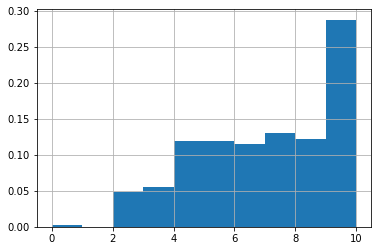

In [306]:
lens = pd.Series([len(h) for h in public_test_hypos])
print(lens.describe())
lens.hist(bins=10, density=True);

In [187]:
k = '151967-N'

In [188]:
id2synset[k]

OrderedDict([('@id', '151967-N'),
             ('@ruthes_name', 'СПОРТИВНЫЙ ПРИЕМ'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              OrderedDict([('@id', '151967-N-740014'),
                           ('#text', 'СПОРТИВНЫЙ ПРИЕМ')]))])

In [189]:
for c in id2hypernym[k]:
    print(c, id2synset[c]['@ruthes_name'])

106552-N СПОСОБ, СРЕДСТВО
106828-N ПРИЕМ (СПОСОБ)
106613-N РОЛЬ, ПОЛОЖЕНИЕ, МЕСТО


In [190]:
rel_df.sample(3)

,@parent_id,@child_id,@name,parent,child
70190,3694-N,116489-N,hypernym,ДИСЦИПЛИНАРНОЕ ВЗЫСКАНИЕ,ВЗЫСКАНИЕ (НАКАЗАНИЕ)
83065,111260-N,111325-N,hyponym,ПЛОХОЙ ПОСТУПОК,НАГЛЫЙ ПОСТУПОК
88196,9144-N,5973-N,hyponym,МОРСКАЯ РЫБА,СЕЛЬДЬ


In [ ]:
rel_df[(rel_df['@parent_id']==k)&&(rel_df['@parent_id']==k)]f

In [168]:
ttest_small.sample(3)

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,gt
2621,116040-N,СКОРНЯК,"116038-N,110125-N",NaN,"[116038-N, 110125-N]","[{116038-N}, {110125-N}]"
15714,111515-N,КСЕНДЗ,"110384-N,7365-N,4545-N",NaN,"[110384-N, 7365-N, 4545-N]","[{110384-N}, {7365-N}, {4545-N}]"
12340,10100-N,"МОРФИН,МОРФИЙ","124322-N,649-N",NaN,"[124322-N, 649-N]","[{124322-N}, {649-N}]"


set()

In [172]:
lens = pd.Series(ttest_small.SYNSET_ID.apply(lambda x: len(id2hyponym.get(x, []))))
lens.describe()

count    300.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: SYNSET_ID, dtype: float64

# Ошибка в метрике

In [191]:
def compute_ap(actual, predicted, k=10):
    if not actual:
        return 0.0

    predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    already_predicted = set()
    skipped = 0
    for i, p in enumerate(predicted):
        if p in already_predicted:
            skipped += 1
            continue
        for parents in actual:
            if p in parents:
                num_hits += 1.0
                score += num_hits / (i + 1.0 - skipped)
                already_predicted.update(parents)
                break

    return score / min(len(actual), k)

In [204]:
actual = [['среднее специальное', 'профессиональное'], ['медицинское', 'профессиональное']]
print(compute_ap(actual, ['среднее специальное', 'медицинское']))
print(compute_ap(actual, ['среднее специальное', 'профессиональное'])) # второй родитель считается не найденным
print(compute_ap(actual, ['медицинское', 'профессиональное'])) # первый родитель считается не найденным
print(compute_ap(actual, ['профессиональное'])) # снова второй родитель считается не найденным
print(compute_ap(actual, ['профессиональное', 'медицинское'])) # должны считать 

1.0
0.5
0.5
0.5
1.0


In [209]:
print(compute_ap([['A', 'C'],['B', 'C']], ['C', 'A'])) # получаем 0.5
print(compute_ap([['B', 'C'],['A', 'C']], ['C', 'A'])) # получаем 1.0

0.5
1.0


Бля, чё-то я задолбался. Наверное, пора спатеньки. 

# Кажется, все параметры придётся подбирать заново

In [60]:
from collections import defaultdict

def add_pair(hypo_id, hyper_id, max_depth=100500):
    if max_depth <= 0:
        return
    if hypo_id in id2hyponym[hyper_id]:
        # the pair is already here
        return 
    if hypo_id in id2hypernym[hyper_id]:
        raise ValueError('{} is already a hypernym of {}, so it cannot become its hyponym'.format(hypo_id, hyper_id))
    for next_hypo in id2hyponym[hypo_id]:
        add_pair(next_hypo, hyper_id, max_depth=max_depth-1)
    for next_hyper in id2hypernym[hyper_id]:
        add_pair(hypo_id, next_hyper, max_depth=max_depth-1)
    id2hyponym[hyper_id].add(hypo_id)
    id2hypernym[hypo_id].add(hyper_id)
        

In [61]:
id2hyponym = defaultdict(set)
id2hypernym = defaultdict(set)
forbidden_id = set(ttest.SYNSET_ID)

hypo_df = rel_df[rel_df['@name']=='hyponym']
for r, row in tqdm(hypo_df.iterrows()):
    hypo_id = row['@child_id']
    hyper_id = row['@parent_id']
    if hypo_id not in forbidden_id and hyper_id not in forbidden_id:
        add_pair(hypo_id, hyper_id, max_depth=1)  # во второй версии поставим максимальную глубину, равную 2

print(len(id2hyponym))
print(max(len(c) for c in id2hyponym.values()))
print(max(len(c) for c in id2hypernym.values()))
print(sum(len(c) for c in id2hypernym.values()))


25816
446
5
34165


In [50]:
import gensim
# this is araneum 2018 ft model from rusvectores
ft = gensim.models.fasttext.FastTextKeyedVectors.load(
    'C:/Users/ddale/Downloads/NLP/rusvectores/model.model'
)
ft.adjust_vectors()

In [51]:
from nltk import wordpunct_tokenize
from string import punctuation

def tokenize(text):
    return [t for t in wordpunct_tokenize(text.lower()) if not all(c in punctuation for c in t)]

def mean_ft(tokens, n=300):
    vecs = [normalize(ft[w]) for w in tokens]
    if len(vecs) == 0:
        return np.zeros(n)
    return normalize(sum(vecs))

def normalize(v):
    return v / sum(v**2)**0.5

In [245]:
from tqdm.auto import tqdm, trange

In [246]:
def text2vec(text):
    return mean_ft(tokenize(text))

In [267]:
ids_long = []
texts_long = []
for id in ids:
    s = id2synset[id]
    senses = s['sense']
    if not isinstance(senses, list):
        senses = [senses]
    texts = {sense['#text'] for sense in senses}
    texts.add(s['@ruthes_name'])
    
    # исключаем все слова, омонимичные с тем, что есть в тестовой выборке 
    senses = {synset_id for w in texts for synset_id in word2sense[w]}
    if senses.intersection(forbidden_id):
        continue
    
    if len(texts) > 1:
        texts.add(' ; '.join(sorted(texts)))
    for text in sorted(texts):
        ids_long.append(id)
        texts_long.append(text)
print(len(ids), len(ids_long))

26837 103891


In [268]:
#vecs = np.stack([mean_ft(tokenize(id2synset[idx]['@ruthes_name'])) for idx in tqdm(ids) ])
vecs = np.stack([mean_ft(tokenize(t)) for t in tqdm(texts_long) ])
vecs.shape

(103891, 300)

In [269]:
from sklearn.neighbors import KDTree
tree = KDTree(vecs)

In [270]:
from collections import Counter

def hypotheses_knn(text, index, ids_list=ids_long, texts_list=texts_long, k=10, verbose=False, decay=0, grand_mult=1):
    # todo: distance decay
    vec = text2vec(text)
    distances, indices = index.query(vec.reshape(1, -1), k=k)
    hypotheses = Counter()
    for i, d in zip(indices.ravel(), distances.ravel()):
        hypers = id2hypernym.get(ids_list[i], set())
        if verbose:
            print(d, 1, ids_list[i], texts_list[i], len(hypers))
        for parent in hypers:
            hypotheses[parent] += np.exp(-d**decay)
            for grandparent in id2hypernym.get(parent, set()):
                hypotheses[grandparent] += np.exp(-d**decay) * grand_mult
    if verbose:
        print(len(hypotheses))
    result = []
    for hypo, cnt in hypotheses.most_common(10):
        if verbose:
            print(cnt, hypo, id2synset[hypo]['@ruthes_name'])
        result.append(hypo)
    return result

In [271]:
import gc
gc.collect()

4356

In [73]:
hypotheses_knn('ВБРАСЫВАНИЕ', index=tree, decay=0.33, k=10, grand_mult=1, verbose=1)

0.0 1 114996-N ВБРАСЫВАНИЕ 0
0.5116056677363932 1 131068-N ЗАБРАСЫВАНИЕ 2
0.5116056677363932 1 119772-N ЗАБРАСЫВАНИЕ 2
0.5116056677363932 1 116671-N ЗАБРАСЫВАНИЕ 1
0.5406045954990208 1 111021-N ВЫБРАСЫВАНИЕ 1
0.5414842330504848 1 114996-N ВБРАСЫВАНИЕ ; ВБРОСИТЬ 0
0.5929697593510923 1 115142-N ОТБРАСЫВАНИЕ 1
0.5929697593510923 1 133422-N ОТБРАСЫВАНИЕ 0
0.5962406770915919 1 115653-N ПЕРЕБРАСЫВАНИЕ 1
0.5962406770915919 1 137813-N ПЕРЕБРАСЫВАНИЕ 2
14
2.1889925173882725 106938-N ПЕРЕМЕСТИТЬ
1.3100085107581332 111022-N БРОСИТЬ (ПЕРЕМЕСТИТЬ)
0.8972362024580601 107325-N ПОКРЫТЬ ПОВЕРХНОСТЬ
0.8789840066301394 106817-N ПРИНУДИТЬ, ЗАСТАВИТЬ
0.44861810122903006 111970-N ОСЫПАТЬ, ОБСЫПАТЬ
0.44861810122903006 106698-N ПОМЕСТИТЬ, НАЙТИ МЕСТО
0.44861810122903006 146751-N ОБРАБОТКА ПОВЕРХНОСТИ
0.44861810122903006 119751-N НАПРАВИТЬ (ПОСЛАТЬ)
0.44861810122903006 115672-N ДОСТАВИТЬ К МЕСТУ НАЗНАЧЕНИЯ
0.44206384181699887 110908-N УДАЛИТЬ НАРУЖУ


['106938-N',
 '111022-N',
 '107325-N',
 '106817-N',
 '111970-N',
 '106698-N',
 '146751-N',
 '119751-N',
 '115672-N',
 '110908-N']

decay=0.33, k=3, grand_mult=1
0.10321460573476703
0.15725806451612903
0.6563390313390313

decay=0.33, k=10, grand_mult=1
0.16934843830005117
0.3588709677419355
0.47189227751025503

decay=0.33, k=30, grand_mult=1
0.23650606972179553
0.4717741935483871
0.5013120110342332

decay=0.33, k=100, grand_mult=1
0.25543194764464927
0.5040322580645161
0.5067769841269841

decay=0.33, k=100, grand_mult=0.99
0.2583937371991808
0.5040322580645161
0.5126531746031746

decay=0.33, k=100, grand_mult=0.9
0.26030985983102917
0.5120967741935484
0.508321616047994

decay=0.33, k=100, grand_mult=0.5
0.2639172907066052
0.5040322580645161
0.5236119047619049

decay=0.33, k=100, grand_mult=0.1
0.2623479902713774
0.4959677419354839
0.5289618015227772

decay=3, k=100, grand_mult=0.5
0.2650841653865847
0.5
0.5301683307731694

decay=1, k=100, grand_mult=0.5 ***
0.26547459037378396
0.5040322580645161
0.5267015873015873

decay=0.33, k=100, grand_mult=0.5 * 
0.2639172907066052
0.5040322580645161
0.5236119047619049

decay=0.1, k=100, grand_mult=0.5 **
0.26458453341013827
0.5080645161290323
0.5207695578231293

decay=0.01, k=100, grand_mult=0.5 
0.26458453341013827
0.5080645161290323
0.5207695578231293



И снова перечитываем всё заново! С более правильным индексом, без антиутечек

decay=1, k=300, grand_mult=0.5
0.24447724654377878
0.5282258064516129
0.4628271537622683

decay=1, k=120, grand_mult=0.5
0.26279761904761906
0.4879032258064516
0.5386265249901614

decay=1, k=100, grand_mult=0.5 * 
0.2677061998634579
0.4879032258064516
0.548687087323451

decay=1, k=80, grand_mult=0.5
0.25930699564772147
0.46774193548387094
0.5543804734537494

decay=1, k=30, grand_mult=0.5
0.2400193612391193
0.45161290322580644
0.5314714427437641

decay=0.8, k=100, grand_mult=0.5
0.2677061998634579
0.4879032258064516
0.548687087323451

decay=1, k=100, grand_mult=0.5
0.2677061998634579
0.4879032258064516
0.548687087323451

decay=1.2, k=100, grand_mult=0.5
0.2682345003413552
0.4879032258064516
0.5497698849971576

decay=2, k=100, grand_mult=0.5
0.27040423920464246
0.4879032258064516
0.5542169530805895

decay=2.5, k=100, grand_mult=0.5
0.2714699074074074
0.49193548387096775
0.551840467516697

decay=3, k=100, grand_mult=0.5 * 
0.2715419120157023
0.49193548387096775
0.5519868375401161

decay=3.5, k=100, grand_mult=0.5
0.26925216547192354
0.4879032258064516
0.5518556779920416

decay=4, k=100, grand_mult=0.5
0.26925216547192354
0.4879032258064516
0.5518556779920416

decay=10, k=100, grand_mult=0.5
0.26544392174432496
0.49193548387096775
0.5395909228901032

decay=3, k=100, grand_mult=0.45
0.2670328234340331
0.4959677419354839
0.5384076439970749

decay=3, k=100, grand_mult=0.5 * 
0.2715419120157023
0.49193548387096775
0.5519868375401161

decay=3, k=100, grand_mult=0.55
0.27112108508277866
0.4838709677419355
0.5603169091710759

In [294]:
texts = ttest_test1.one_text.drop_duplicates()
small_hypos = [hypotheses_knn(txt, index=tree, decay=3, k=100, grand_mult=0.5)  for txt in tqdm(texts)]

aps, _ = evaluate_mine(small_hypos, texts, ttest_test1)
print(aps.mean())
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()


0.2715419120157023
0.49193548387096775
0.5519868375401161


count    248.000000
mean       0.271542
std        0.375511
min        0.000000
25%        0.000000
50%        0.000000
75%        0.500000
max        1.000000
dtype: float64

In [71]:
aps.head(10)

0    0.2
1    0.0
2    0.0
3    1.0
4    0.0
5    0.0
6    1.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [72]:
texts.iloc[0:10]

19        ВБРАСЫВАНИЕ
315       ПРИСТЫКОВКА
357         КОРОМЫСЛО
358    НЕВРОПАТОЛОГИЯ
493         МИНЕРАЛКА
513             НЫРОК
613          КАЛАМБУР
628          КОРОЛЕВА
651            КОБЫЛА
819        САЛАМАНДРА
Name: one_text, dtype: object

In [295]:
public_test_hypos = [hypotheses_knn(t, index=tree, decay=3, k=100, grand_mult=0.5) for t in tqdm(public_test_nouns.noun)]
sub = prepare_submission(public_test_nouns.noun, public_test_hypos, id2synset)
sub.to_csv('nouns_v08_ft_knn_grn05_k100_d3.tsv', sep='\t', encoding='utf-8', header=None, index=None)
sub.head(15)

,noun,result,result_text
0,АБДОМИНОПЛАСТИКА,106536-N,МАТЕРИАЛ ДЛЯ ИЗГОТОВЛЕНИЯ
1,АБДОМИНОПЛАСТИКА,106555-N,ТЕХНИЧЕСКОЕ УСТРОЙСТВО
2,АБДОМИНОПЛАСТИКА,118950-N,"КРАСОТА, КРАСА"
3,АБДОМИНОПЛАСТИКА,4503-N,ТЕКСТИЛЬНАЯ ПРОДУКЦИЯ
4,АБДОМИНОПЛАСТИКА,919-N,СИНТЕТИЧЕСКИЕ МАТЕРИАЛЫ
5,АБДОМИНОПЛАСТИКА,4567-N,ОРГТЕХНИКА
6,АБДОМИНОПЛАСТИКА,8218-N,ИЗДЕЛИЕ ЛЕГКОЙ ПРОМЫШЛЕННОСТИ
7,АБДОМИНОПЛАСТИКА,106553-N,"ПРИСПОСОБЛЕНИЕ, ИНСТРУМЕНТ"
8,АБДОМИНОПЛАСТИКА,510-N,ЭЛЕКТРОННОЕ ОБОРУДОВАНИЕ
9,АБДОМИНОПЛАСТИКА,132393-N,ПРОДУКЦИЯ ПРОИЗВОДСТВЕННО-ТЕХНИЧЕСКОГО НАЗНАЧЕНИЯ


# Ручной разбор

Итак, что мы имеем на сегодняшний день:
* Скор вдвое хуже, чем у лидера
* 50% запросов - не найдены, 50% - плохо проранжированы

Идеи:
* Изучить, для какой доли тестовой выборки гипероним вообще есть в дереве. Оказывается, целых 98%
  * те около 2%, для кого гиперонимов нет - почти на 100% топонимы или национальности. Для них можно сделать отдельный хак или поглядеть в Википедии. 
* понять, насколько хорошо справляется knn
  * 

In [94]:
possible_parents = set(id2hyponym.keys())

In [97]:
p_share = ttest_test1.parents_list.apply(lambda x: np.mean([c in possible_parents for c in x]))
p_share.describe()

count    342.000000
mean       0.980019
std        0.108338
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: parents_list, dtype: float64

In [99]:
ttest_test1[p_share.values < 1]

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
938,102221-N,ОБЬ,"136801-N,134530-N",NaN,"[136801-N, 134530-N]",0.820223,ОБЬ
5198,100406-N,СТЕРЛИТАМАК,"135115-N,134530-N",NaN,"[135115-N, 134530-N]",0.821024,СТЕРЛИТАМАК
5307,102172-N,СЕРГАЧ,"136800-N,134530-N",NaN,"[136800-N, 134530-N]",0.832989,СЕРГАЧ
5428,105391-N,"НИДЕРЛАНДЕЦ,НИДЕРЛАНДКА,ГОЛЛАНДКА,ГОЛЛАНДЕЦ","106128-N,106123-N",житель или уроженец Голландии,"[106128-N, 106123-N]",0.828110,НИДЕРЛАНДКА
6328,100681-N,ВОРОНЕЖ,"136766-N,134530-N",NaN,"[136766-N, 134530-N]",0.834573,ВОРОНЕЖ
6930,101688-N,ИВАНГОРОД,"136785-N,134530-N",NaN,"[136785-N, 134530-N]",0.829863,ИВАНГОРОД
7568,105437-N,"ТУРЧАНКА,ТУРОК","106148-N,106147-N,106131-N","житель или уроженец Турции, представитель наро...","[106148-N, 106147-N, 106131-N]",0.837287,ТУРОК
7578,105612-N,"ХАКАС,ХАКАСКА","106148-N,106147-N,106131-N",NaN,"[106148-N, 106147-N, 106131-N]",0.834086,ХАКАСКА
10321,103003-N,АМУРСК,"136195-N,134530-N",NaN,"[136195-N, 134530-N]",0.823959,АМУРСК
12668,105697-N,УСТЬ-ИЛИМСК,"134529-N,134530-N",NaN,"[134529-N, 134530-N]",0.833169,УСТЬ-ИЛИМСК


In [144]:
train_n.query('SYNSET_ID=="105612-N"')

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
7578,105612-N,"ХАКАС,ХАКАСКА","106148-N,106147-N,106131-N",NaN,"[106148-N, 106147-N, 106131-N]",0.834086,ХАКАСКА
7579,105612-N,"ХАКАС,ХАКАСКА","100046-N,7739-N",NaN,"[100046-N, 7739-N]",0.834086,ХАКАСКА
7580,105612-N,"ХАКАС,ХАКАСКА","3291-N,132681-N,1310-N",NaN,"[3291-N, 132681-N, 1310-N]",0.834086,ХАКАСКА


In [100]:
id2hypernym['136801-N']

set()

In [147]:
id2synset['3291-N']

OrderedDict([('@id', '3291-N'),
             ('@ruthes_name', 'РОССИЯНЕ'),
             ('@definition',
              'жители или граждане России или выходцы из этой страны'),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '3291-N-185764'),
                            ('#text', 'НАСЕЛЕНИЕ РОССИЙСКИЙ ФЕДЕРАЦИЯ')]),
               OrderedDict([('@id', '3291-N-207832'),
                            ('#text', 'НАРОД РОССИЙСКИЙ ФЕДЕРАЦИЯ')]),
               OrderedDict([('@id', '3291-N-110915'),
                            ('#text', 'РОССИЙСКИЙ ГРАЖДАНИН')]),
               OrderedDict([('@id', '3291-N-207833'),
                            ('#text', 'НАРОД РОССИЯ')]),
               OrderedDict([('@id', '3291-N-207815'),
                            ('#text', 'ГРАЖДАНИН РОССИЯ')]),
               OrderedDict([('@id', '3291-N-185762'),
                            ('#text', 'НАСЕЛЕНИЕ РОССИЯ')]),
               OrderedDict([('@id', '3291-N-1669

In [109]:
import requests
from bs4 import BeautifulSoup

In [323]:
STRESS_CHAR = '́'

def get_definition(query):
    t = requests.get('https://ru.wikipedia.org/w/index.php?search={}'.format(query)).text
    soup = BeautifulSoup(t)
    d = soup.find('div', {'id': 'mw-content-text'}).find('div')
    for c in d.children:
        if c.name=='p':
            break
    return c.text.replace(STRESS_CHAR, '').replace('\xa0', ' ')

In [366]:
def get_definition(query, mobile=True):
    if mobile:
        domain = 'ru.m.wikipedia.org'
    else:
        domain = 'ru.wikipedia.org'
    url = 'http://{}/w/index.php?search={}'.format(domain, query)
    t = requests.get(url).text
    soup = BeautifulSoup(t)
    d = soup.find('div', {'id': 'mw-content-text'}).find('div')
    if mobile:
        d = d.find('section')
    for c in d.children:
        if c.name=='p':
            break
    return c.text.replace(STRESS_CHAR, '').replace('\xa0', ' ')

Примерно 1-1.3s занимает поход на wikipedia.org, и столько же, увы, на мобильную версию. 

In [369]:
get_definition('литва', mobile=True)

'Литва (лит. Lietuva), официальное название — Литовская Республика (лит. Lietuvos Respublika) — государство, расположенное в северной части Европы. Столица страны — Вильнюс.\n'

In [373]:
%%timeit
get_definition('литва', mobile=False)

1.35 s ± 90.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [317]:
word2sense['центр Московской области'.upper()]

set()

In [151]:
texts = ttest_dev.one_text.drop_duplicates()
small_hypos = [hypotheses_knn(txt, index=tree, decay=1, k=300, grand_mult=0.5)  for txt in tqdm(texts)]

aps, _ = evaluate_mine(small_hypos, texts, ttest_dev)
print(aps.mean())
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()


0.24984757136044689
0.5793991416309013
0.4312184009406232


count    233.000000
mean       0.249848
std        0.323905
min        0.000000
25%        0.000000
50%        0.125000
75%        0.400000
max        1.000000
dtype: float64

In [152]:
aps[:10]

0    0.000000
1    0.375000
2    0.125000
3    0.000000
4    0.000000
5    0.500000
6    0.000000
7    0.000000
8    0.142857
9    0.100000
dtype: float64

```
129     ВООДУШЕВЛЕНИЕ - в тестовых данных имелся в виду процесс, а в обучающих нашлось состояние. Спросить, как быть. 
134            МОСКВА - в GT много специфической информации, которая по соседям плохо собирается. Но всё есть в вики. 
178        ЯДОВИТОСТЬ - редкое слово, эмбеддинг не оч информативен. Можно поискать от прилагательного. И многозначное.
355             БАГЕТ - многозначное слово, поймал не то значение. 
384             ВИЛОК - многозначное слово ("вилка"), поймал не то значение. в вики есть дизамбигуация, но хз как юзать
425         КАЛЕНДУЛА - примерно поймал смысл, но не поймал биологические факты. есть в вики. 
552      ЭЛАСТИЧНОСТЬ - многозначное слово, поймал не то
635         НОВОВЯТСК - поймал что это город, но GT - что это город Кировской области. Нужны факты. 
932        ГОЛЕНОСТОП - это сустав, а knn начал вытягивать в основном болезни (в их названиях есть это слово)
1075            ЗАМОК - снова поймал не то значение многозначного слова. 
```

In [154]:
texts[:10]

129     ВООДУШЕВЛЕНИЕ
134            МОСКВА
178        ЯДОВИТОСТЬ
355             БАГЕТ
384             ВИЛОК
425         КАЛЕНДУЛА
552      ЭЛАСТИЧНОСТЬ
635         НОВОВЯТСК
932        ГОЛЕНОСТОП
1075            ЗАМОК
Name: one_text, dtype: object

In [233]:
for c in small_hypos[9]:
    print(c, id2synset[c]['@ruthes_name'])

109543-N ЗАПОР, ЗАПОРНОЕ УСТРОЙСТВО
106553-N ПРИСПОСОБЛЕНИЕ, ИНСТРУМЕНТ
2525-N СООРУЖЕНИЕ, ПОСТРОЙКА
106451-N МЕСТО В ПРОСТРАНСТВЕ
2526-N ЗДАНИЕ
106573-N ПОМЕЩЕНИЕ, ВНУТРЕННОСТЬ ЗДАНИЯ
107233-N СТЕРЖЕНЬ (ПРЕДМЕТ)
537-N СТРОИТЕЛЬНЫЕ КОНСТРУКЦИИ
479-N ЖИЛОЕ ЗДАНИЕ
107087-N ОТВЕРСТИЕ


In [303]:
d = ttest_dev.query('one_text=="МОСКВА"')
d

,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
134,2641-N,МОСКВА,"9923-N,242-N,2637-N",NaN,"[9923-N, 242-N, 2637-N]",0.803397,МОСКВА
135,2641-N,МОСКВА,"134783-N,242-N",NaN,"[134783-N, 242-N]",0.803397,МОСКВА
136,2641-N,МОСКВА,"134321-N,134313-N",NaN,"[134321-N, 134313-N]",0.803397,МОСКВА
137,2641-N,МОСКВА,"3208-N,242-N,151357-N",NaN,"[3208-N, 242-N, 151357-N]",0.803397,МОСКВА


In [309]:
id2synset['9923-N']

OrderedDict([('@id', '9923-N'),
             ('@ruthes_name', 'ГОРОД ФЕДЕРАЛЬНОГО ЗНАЧЕНИЯ'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              OrderedDict([('@id', '9923-N-123297'),
                           ('#text', 'ГОРОД ФЕДЕРАЛЬНЫЙ ЗНАЧЕНИЕ')]))])

In [313]:
word2sense['ГОРОД ФЕДЕРАЛЬНОГО ЗНАЧЕНИЯ']

{'9923-N'}

In [306]:
len(word2sense)

85334

In [304]:
for pp in d.parents_list:
    print(' | '.join([ id2synset[c]['@ruthes_name'] for c in pp]))

ГОРОД ФЕДЕРАЛЬНОГО ЗНАЧЕНИЯ | ГОРОД | СУБЪЕКТ РОССИЙСКОЙ ФЕДЕРАЦИИ
МЕГАПОЛИС, ГОРОД-МИЛЛИОНЕР | ГОРОД
ЦЕНТР ЦЕНТРАЛЬНОГО ФЕДЕРАЛЬНОГО ОКРУГА | ЦЕНТР ФЕДЕРАЛЬНОГО ОКРУГА РФ
СТОЛИЦА ГОСУДАРСТВА | ГОРОД | АДМИНИСТРАТИВНЫЙ ЦЕНТР


In [254]:
hypotheses_knn('ЗАМОК', index=tree, decay=1, k=100, grand_mult=0.5, verbose=True)

0.0 1 114707-N ЗАМОК 1
0.5208078430396857 1 153372-N ЗАЩЕЛКА ЗАМОК 1
0.5352649885284523 1 114704-N КЛЮЧ ЗАМОК 1
0.575655892650233 1 114707-N ЗАМОК ; ЗАМОК ДЛЯ ЗАПИРАНИЕ ; ЗАМОК ДЛЯ ЗАПИРАНИЯ ; ЗАМОЧЕК 1
0.5824655840310942 1 148407-N ЗАМОК С КОД ; ЗАМОК С ШИФР ; КОДОВЫЙ ЗАМОК ; НАБОРНЫЙ ЗАМОК 1
0.6217534688634724 1 148434-N СКВАЖИНА ЗАМОК 1
0.6266361900893433 1 148407-N КОДОВЫЙ ЗАМОК 1
0.6384004164972609 1 148407-N НАБОРНЫЙ ЗАМОК 1
0.658082657400115 1 148434-N ОТВЕРСТИЕ ЗАМОК 1
0.7110617743886067 1 114707-N ЗАМОК ДЛЯ ЗАПИРАНИЯ 1
0.7230722398769986 1 114704-N КЛЮЧ К ЗАМОК 1
0.7320238734875024 1 114707-N ЗАМОК ДЛЯ ЗАПИРАНИЕ 1
0.7457962149853562 1 148407-N ЗАМОК С ШИФР 1
0.7664942600797695 1 114704-N ЗАМОЧНЫЙ КЛЮЧ ; КЛЮЧ ; КЛЮЧ ЗАМОК ; КЛЮЧ К ЗАМКУ ; КЛЮЧ К ЗАМОК ; КЛЮЧИК 1
0.7784294865185707 1 148407-N ЗАМОК С КОД 1
0.7851388881603731 1 153372-N ЗАЩЕЛКА ; ЗАЩЕЛКА ЗАМКА ; ЗАЩЕЛКА ЗАМОК 1
0.8107683417167264 1 148434-N ЗАМОЧНАЯ СКВАЖИНА ; ЗАМОЧНЫЙ СКВАЖИНА ; ОТВЕРСТИЕ ЗАМОК ; СКВАЖИНА ДЛЯ КЛ

['109543-N',
 '106553-N',
 '107233-N',
 '106451-N',
 '107087-N',
 '114707-N',
 '107496-N',
 '107519-N',
 '109550-N',
 '146447-N']

In [272]:
pst = set(public_test_nouns.noun)
tst = set(ttest_dev.one_text)
lst = set(texts_long)
print(len(pst), len(pst.intersection(lst))) 
print(len(tst), len(tst.intersection(lst))) # было 61 из 233

762 0
233 0


Ага, а вот и обнаруженная проблема: в настоящей тестовой выборке нет слов с кучей значений, а в моей искуственной - есть. Происходит антиутечка, которая, возможно, занижает мои метрики и заставляет увеличивать число соседей и сглаживание. 

Видимо, нужно исключить из индекса не только мои синсеты, но и другие синсеты, содержащие то же слово. 

In [260]:
public_test_nouns.noun.sample(10)

541         РЕВМАТОЛОГ
529    РАЗБАЛАНСИРОВКА
395         НЕГАТИВИЗМ
297        КРОЛЬЧАТНИК
344      МАШИНОВЕДЕНИЕ
505       ПРИВАТИЗАТОР
440              ПАЛАШ
637      ТАНКОСТРОЕНИЕ
256              КИЗИЛ
10          АКСЕЛЬБАНТ
Name: noun, dtype: object

In [322]:
import gensim
# this is araneum 2018 ft model from rusvectores
m = gensim.models.fasttext.FastTextKeyedVectors.load(
    'C:/Users/ddale/Downloads/NLP/rusvectores/web.bin'
)
m.adjust_vectors()

UnpicklingError: invalid load key, '3'.

In [399]:
s = ttest_dev.sample(1).SYNSET_ID.iloc[0]
d = ttest_dev[ttest_dev.SYNSET_ID==s]
d


,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text
425,108310-N,"НОГОТКИ,КАЛЕНДУЛА","965-N,144172-N",NaN,"[965-N, 144172-N]",0.804773,КАЛЕНДУЛА
426,108310-N,"НОГОТКИ,КАЛЕНДУЛА","4789-N,144172-N",NaN,"[4789-N, 144172-N]",0.804773,КАЛЕНДУЛА


In [400]:
for pp in d.parents_list:
    print(' | '.join([ id2synset[c]['@ruthes_name'] for c in pp]))

ЦВЕТКОВОЕ РАСТЕНИЕ | РАСТЕНИЕ
ТРАВЯНИСТОЕ РАСТЕНИЕ | РАСТЕНИЕ


In [401]:
get_definition(d.one_text.iloc[0], mobile=False)

'Календула, или Ноготки (лат. Caléndula) — род травянистых растений семейства Астровые (Asteraceae).\n'

In [402]:
id2synset['142193-N']

OrderedDict([('@id', '142193-N'),
             ('@ruthes_name', 'ЕВРОПЕЙСКАЯ СТРАНА'),
             ('@definition', ''),
             ('@part_of_speech', 'N'),
             ('sense',
              [OrderedDict([('@id', '142193-N-216006'),
                            ('#text', 'ГОСУДАРСТВО ЕВРОПА')]),
               OrderedDict([('@id', '142193-N-216000'),
                            ('#text', 'СТРАНА ЕВРОПА')]),
               OrderedDict([('@id', '142193-N-216005'),
                            ('#text', 'ЕВРОПЕЙСКИЙ ГОСУДАРСТВО')]),
               OrderedDict([('@id', '142193-N-215999'),
                            ('#text', 'ЕВРОПЕЙСКИЙ СТРАНА')])])])